# Processing & Feature Engineering

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

import datetime
# import time
# import operator
# from __future__ import division

np.random.seed(0)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Processing

In [2]:
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users.csv')
labels = df_train['country_destination'].values
df_train = df_train.drop(['country_destination'], axis=1)
id_test = df_test['id']
piv_train = df_train.shape[0]

In [3]:
#Creating a DataFrame with train+test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
#Removing id and date_first_booking
df_all = df_all.drop(['id', 'date_first_booking'], axis=1)
#Filling nan
df_all = df_all.fillna(-1)

## Date Engineering

In [4]:
#date_account_created
dac = np.vstack(df_all.date_account_created.astype(str).apply(
    lambda x: list(map(int, x.split('-')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all = df_all.drop(['date_account_created'], axis=1)

#timestamp_first_active
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(
    lambda x: list(map(int, [x[:4],
    x[4:6],x[6:8],x[8:10],
    x[10:12],x[12:14]]))).values)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all['tfa_hour'] = tfa[:,3]
# df_all['tfa_min'] = tfa[:,4]
# df_all['tfa_sec'] = tfa[:,5]
df_all = df_all.drop(['timestamp_first_active'], axis=1)

## Date functions for additional features

In [5]:
def numDaysDiff(dates):
    # Calculates the number of days between the date the
    # account was created and the time of first activity
    firstDate = datetime.date(dates[0], dates[1], dates[2])#year, month, day
    secondDate = datetime.date(dates[3], dates[4], dates[5])
    timeDiff = firstDate - secondDate
    timeSections = str(timeDiff).split()[0]
    if timeSections == '0:00:00':
        return 0
    else:
        return abs(int(str(timeSections).split()[0]))

def daysTillChristmas(dates):
    # number of days from time first active till christmas
    userDate = datetime.date(dates[0], dates[1], dates[2])
    xmasDate = datetime.date(dates[0], 12, 25)
    timeDiff = userDate - xmasDate
    timeSections = str(timeDiff).split()[0]
    if timeSections == '0:00:00':
        return 0
    else:
        return abs(int(str(timeSections).split()[0]))

def daysTillThanksgiving(dates):
    # number of days from time first active, 
    # estimate since thanksgiving is different every year
    userDate = datetime.date(dates[0], dates[1], dates[2])
    thanksgivingDate = datetime.date(dates[0], 11, 23)
    timeDiff = userDate - thanksgivingDate
    timeSections = str(timeDiff).split()[0]
    if timeSections == '0:00:00':
        return 0
    else:
        return abs(int(str(timeSections).split()[0]))

In [6]:
cols = ['dac_year','dac_month','dac_day','tfa_year','tfa_month','tfa_day']
df_all['days_btw_dac_tfa'] = [numDaysDiff(t[cols]) for i,t in df_all.iterrows()]
cols = ['tfa_year','tfa_month','tfa_day']
df_all['tfa_thanksgiving'] = [daysTillThanksgiving(x) for i,x in df_all[cols].iterrows()]
df_all['tfa_xmas'] = [daysTillChristmas(x) for i,x in df_all[cols].iterrows()]

### Age Engineering

In [10]:
ages = df_all.age.values
ages[ages == -1] = 0
ages = ages.astype(int)
agesCount = np.bincount(ages)
ages = np.unique(ages)
ageindex = np.nonzero(agesCount)[0]
agesplot = np.vstack((ageindex, agesCount[ageindex])).T

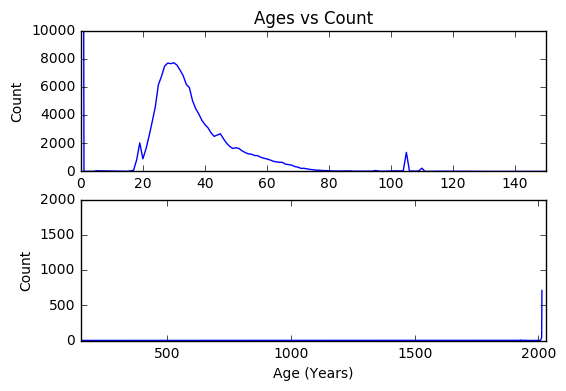

In [11]:
#agesplot
plt.subplot(2, 1, 1)
plt.plot(agesplot[:,0], agesplot[:,1])
plt.title('Ages vs Count')
# plt.xlabel('Age (Years)')
plt.ylabel('Count')
plt.ylim(0,10000)
plt.xlim(0,150)
plt.subplot(2, 1, 2)
plt.plot(agesplot[:,0], agesplot[:,1])
plt.xlabel('Age (Years)')
plt.ylabel('Count')
plt.ylim(0,2000)
plt.xlim(150,2030)
plt.show()

In [12]:
wrongAges = df_all.age[(df_all.age > 151) & (df_all.age < 2001)]
df_all.loc[wrongAges, 'age'] = 2015 - df_all.loc[wrongAges, 'age']
df_all.loc[(df_all.age > 85) | (df_all.age < 15), 'age'] = -1
df_all.age.fillna(-1, inplace = True)
bins = [-1, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
df_all['age_group'] = np.digitize(df_all['age'], bins, right=True)

In [16]:
av = df_all['age'].values
df_all['age'] = np.where(np.logical_or(av<15, av>85), -1, av)
df_all.age = df_all.age.astype('int')

## Sessions Data

In [19]:
#Load Data
sessions = pd.read_csv('sessions.csv')
sessions.rename(columns = {'user_id': 'id'}, inplace=True)

In [ ]:
action_count = sessions.groupby(['id', 'action'])['secs_elapsed'].agg(len).unstack()
action_type_count = sessions.groupby(['id', 'action_type'])['secs_elapsed'].agg(len).unstack()
action_detail_count = sessions.groupby(['id', 'action_detail'])['secs_elapsed'].agg(len).unstack()
device_type_sum = sessions.groupby(['id', 'device_type'])['secs_elapsed'].agg(sum).unstack()

sessions_data = pd.concat([action_count, action_type_count, action_detail_count, device_type_sum],axis=1)
sessions_data.columns = sessions_data.columns.map(lambda x: str(x) + '_count')

# Most used device
sessions_data['most_used_device'] = sessions.groupby('id')['device_type'].max()

users = users.join(sessions_data, on='id')

# To do list dg:
*explore date_account_created, date_first_active, timestamp_first active; drop these features?, change to date type? pd.to_datetime?
*date_account_created = pd.to_datetime, date_first_active = pd.to_datetime, date_account_created = pd.DatetimeIndex, date_first_active = pd.DatetimeIndex
*keep splitted data (ex. tfa_day, tfa_month...)
*encode user_id???
    le = LabelEncoder()
    sessions['user_id'] = le.fit_transform(sessions['user_id'].astype(str))
    sessions_ids = sessions['user_id'].unique()
*more statistics for user sessions

# To do list for tij:
one-hot Encoding categorical features (start wiht day of week and stuff)